# Ejercicio B1
Miguel Hortelano Busto y Francisco Olayo González Rodríguez 

Como para estos clústerings resultantes, al no tener un conjunto de etiquetas verdaderas "Ground Truth", utilizamos métricas que no necesiten de ella. En nuestro caso optaremos por los coeficientes de siluteta (silhouette). También es oportuno

Carga de paquetes a utilizar en el entregable.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import support_functions as sp
import seaborn as sns
import pandas as pd
import matplotlib as mpl

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import  confusion_matrix , cohen_kappa_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture

### Ejercicio 1
Usar algún algoritmo de clustering sobre todos los datos sin emplear las etiquetas para obtener una primera clasificación. Definir una estrategia para clasificar nuevos ejemplos y obtener el mapa de clasificación final de toda la imagen. Obviamente, al no haber empleado las etiquetas de las clases puede que nuestro mapa de clasificación basado en clustering no tenga mucha relación con las clases predefinidas.

Al no tener un conjunto de etiquetas con las que comparar los resultados de nuestro clustering recurriremos a métodos que evaluen la cohesión de nuestros clústers, como es el método silhouette. Obtenemos una puntuación entre 1 y -1, cuanto más alto sea este valor más acorde con el clúster asignado estará. 

Tras probar varíos métodos de clústering llegamos a las siguientes conclusiones:
-  Los métodos probados con mejores puntuaciones de silhouette son el kmeans y la mixtura de gaussianas con covarianza esférica.

-  Para pocas clases ambos métodos dan clases similares y puntuaciones algo mejores para kmeans. Mientras si utilizamos números altos de clústers, alrededor del número de clases que tiene el conjunto original, las mixturas gaussianas sobresalen mucho más (aún incluso teniendo peores puntuaciones que los casos con menos clústers). 

-  Las puntuaciones del índice de silhouette medio son bajas. Este ha sido calculado tomando la distáncia euclidea. Si damos un vistazo a los datos vemos que tenemos randiancias espectrales con valores altos y sin normalizar, por lo que el gran número de datos y su rango de valores puede influir en la interpretación de las distancias. Tal vez estas mismas clases teniendo en cuenta la emisión de la superfície en vez de la radiancia, menos características o con otras unidades dieran mejores medidas de coherencia.

-  Aumentar el número de clústers empeora su cohesión, icluso alcanzando a obtener más puntuaciones negativas que positivas en algunos clústers, esto es indicativo de un número de clústers incorrecto. Por ello sería ideal quedarnos con 8 o 9 clústers que dibujan una imagen más o menos interpretable en la que se ven parcelas de diferentes etiquetas y se distingue también el espacio que las separa.


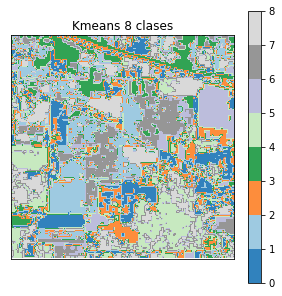

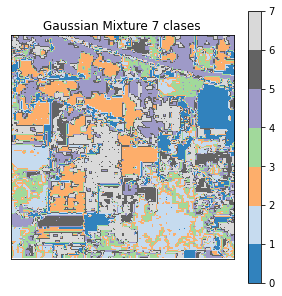

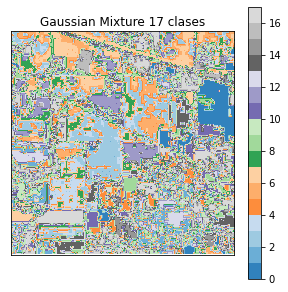

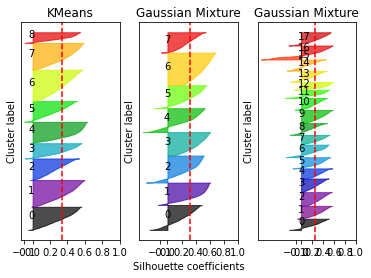

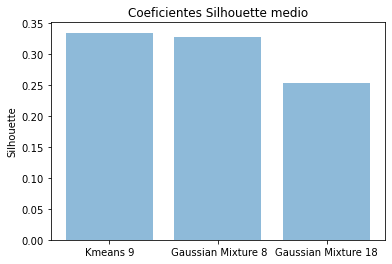

In [2]:
# X e Y son matrices, XL y Yl están vectorizadas y sin etiquetas 0
X,Y,Xl,Yl = sp.aviris_data_load()

#Las etiquetas van de 1 a 16
n_clusters = np.arange(2,20)
X_reshape = X.reshape([145*145,220])

#%% Definitivos
clstrs = KMeans(n_clusters = 9,random_state = 100 ).fit(X_reshape)#Kmeans 9 clusters
clstrs_predictions = clstrs.predict(X_reshape)
clstrs_Y_K9 = clstrs_predictions

clstrs =GaussianMixture(n_components = 8,covariance_type = "spherical")#Mixtura 8 clusters
clstrs_Y_G8 = clstrs.fit_predict(X_reshape)

clstrs =GaussianMixture(n_components = 18,covariance_type = "spherical")#Mixtura 18 clusters
clstrs_Y_G18 = clstrs.fit_predict(X_reshape)

sp.draw_image(clstrs_Y_K9,"Kmeans")#función definida que pinta un mapa de las clases
sp.draw_image(clstrs_Y_G8,"Gaussian Mixture")
sp.draw_image(clstrs_Y_G18,"Gaussian Mixture")

sp.draw_silhouette_plus(X_reshape,clstrs_Y_K9,clstrs_Y_G8,clstrs_Y_G18)#función definida que dibuja los silhuette de los 3 casos

### Ejercicio 2
Para aplicar algoritmos de aprendizaje supervisado simularemos la escasez de muestras etiquetadas empleando solo 5000 muestras con sus etiquetas. Sin embargo, la selección de estas muestras no la vamos a hacer de forma aleatoria sino que vamos a emplear algoritmos de clustering para reducir el número de muestras pero preservando la distribución de los datos de entrada y de las clases definidas.  Primero, separar los datos en función de su etiqueta de clase. En cada subconjunto, aplicar algún algoritmo de clustering y definir una estrategia para obtener un subconjunto reducido que sea representativo del conjunto inicial.

Con intención de reducir los datos manteniendo la estructura de las clases separaremos primero los datos en subconjuntos de píxeles según su etiqueta. Luego a cada subconjunto le aplicaremos un kmeans para obtener agrupaciones de las que obtendremos los nuevos puntos de datos. Utilizaremos el número de clústers que mantendrá la proporción de píxeles en el conjunto original y en el nuevo. Extraemos los centroides de estos clústers, pero no los usaremos directamente, pues podemos obtener puntos que se alejen de la distribución original (si la distribución fuera una circunferencia obtendríamos un punto en el centro, donde no hay nada). En su lugar seleccionamos el punto más cercano al centroide.

Repitiendo el proceso en todas las clases  y agrupamos los puntos resultantes en el nuevo conjunto que mantiene la proporción de puntos de cada clase y la distribución de los puntos.

In [9]:
def data_reducer():
    X,Y,Xl,Yl = sp.aviris_data_load()

    n_tags = max(Yl)
    ratio = 5000/Xl.shape[0]
    #separamos según etiqueta
    tag_list = np.arange(1,n_tags+1)#lista de etiquetas
    tag_index_list = [np.where(Yl == i) for i in tag_list]#lista con las posiciones de cada etiqueta
    #subconjuntos de Yl y Xl de cada etiqueta
    X_index_sample= [Xl[indx,:] for indx in tag_index_list]
    
    
    #preparamos los vectores reducidos
    X_reduced = []
    Y_reduced = []
    
    #Llenamos los libros reducidos
    for i in range(len(tag_list)):
        
        #hacemos clústering del subconjunto con etiqueta i
        data = X_index_sample[i][0,:,:]
        n_points_reduced = int(np.ceil(data.shape[0]*ratio))#aseguramos que se mantenga la proporción de puntos por clase
        cluster = KMeans(n_points_reduced).fit(data)
        centers = cluster.cluster_centers_.squeeze()#obtenemos los centros
        
        newdata = list()
        
        #Seleccionamos el punto más cercano al centroide para evitar distorisionar la distribución de los puntos
        for z in range(centers.shape[0]):
            d = [np.linalg.norm(data[j,:]-centers[z,:]) for j in range(data.shape[0])]
            indx = d.index(min(d))
            newdata.append(data[indx])
            
            
        X_reduced.append(newdata)
        Y_reduced.append(np.ones(n_points_reduced)*tag_list[i])
    
    #Pegamos los resultados uno tras otro
    X_reduced = np.concatenate(X_reduced)
    Y_reduced = np.concatenate(Y_reduced)
    
    return((X_reduced,Y_reduced))

X_reduced, Y_reduced = data_reducer()

### Ejercicio 3 
Utilizar algoritmos supervisados sobre el conjunto reducido de entrenamiento para obtener la clasificación de la imagen. Se debe obtener una aproximación del error de clasificación en test utilizando una partición del conjunto de entrenamiento. Se pueden obtener también resultados cualitativos representado las imágenes de clasificación.

En este apartado, hemos probado varios clasificadores supervisados, y al final hemos decidido utilizar un árbol clasificador, y un KNN (vecinos próximos).

NameError: name 'kappa' is not defined

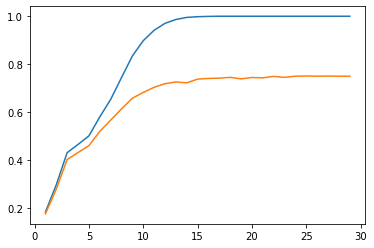

In [10]:
## Tree classifier ##
tag_list = np.arange(1,17)
kappa_train = []
kappa_test = []
criterion = 'gini'
max_depth = None

Xtr, Xts, ytr, yts = train_test_split(X_reduced, Y_reduced, test_size=0.3,random_state = 20)

nn = np.arange(1,30)
for i in nn:
    tree =  RandomForestClassifier(n_estimators=200, criterion=criterion, random_state=100,max_depth = i)
    tree.fit(Xtr, ytr)
    
    ytree = tree.predict(Xtr)
    Conf_matrix_tree = confusion_matrix(ytr, ytree)
    Kappa_tree = cohen_kappa_score(ytr, ytree)
    kappa_train.append(Kappa_tree)
    
    ytree = tree.predict(Xts)
    Conf_matrix_tree = confusion_matrix(yts, ytree)
    Kappa_tree = cohen_kappa_score(yts, ytree)
    kappa_test.append(Kappa_tree)

    
figure, kppa = plt.subplots()
kppa.plot(nn,kappa_train,label = "Entrenamiento")
kppa.plot(nn,kappa_test,label = "testeo")
kappa.axvline(x=8, color="red", linestyle="--")
plt.legend()

Se puede observar como el índice Cohen-kappa es moderadamente bajo (0.57), y tanto en la matriz de confusión como en la imágen de la clasificación, se ve claramente como hay clases que están mal caracterizadas y producen bastante ruido en la imágen de clasificación.

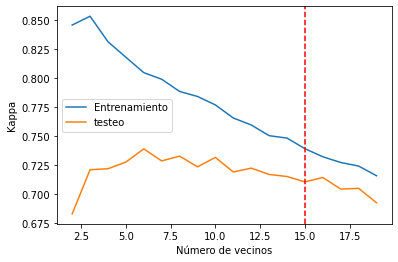

In [30]:
Xtr, Xts, ytr, yts = train_test_split(X_reduced, Y_reduced, test_size=0.3,random_state = 150)
#%% KNN
tag_list = np.arange(1,17)

kappa_train = []
kappa_test = []
nn = np.arange(2,20)

# entrenamos modelos para cada numero de vecinos y preparamos una gráfica comparativa
for i in nn:
    modelo = KNeighborsClassifier(n_neighbors=i,
                                  weights='uniform',
                                  algorithm='auto',
                                  leaf_size=40, p=2,
                                  metric='cosine',
                                  metric_params=None,
                                  n_jobs=-1).fit(Xtr,ytr)
    pred = modelo.predict(Xts)
    kappa_test.append(cohen_kappa_score(yts,pred))
    pred = modelo.predict(Xtr)
    kappa_train.append(cohen_kappa_score(ytr,pred))


figure, (kppa) = plt.subplots(1)
kppa.plot(nn,kappa_train,label = "Entrenamiento")
kppa.plot(nn,kappa_test,label = "testeo")
kppa.axvline(x=15, color="red", linestyle="--")
kppa.set_ylabel("Kappa")
kppa.set_xlabel("Número de vecinos")
kppa.set_title("")
plt.legend()

Cohen-kappa 0.7102644723185234


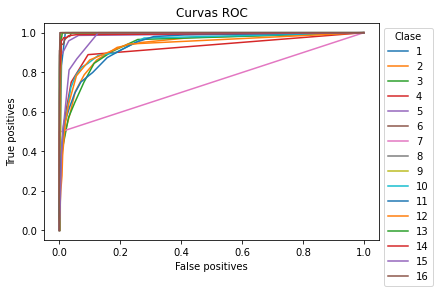

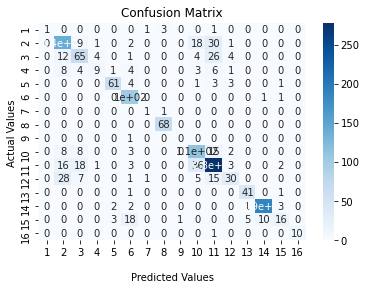

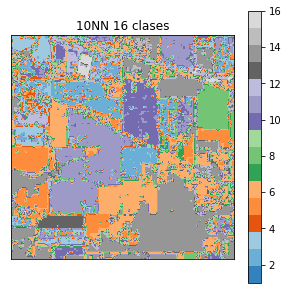

In [29]:
modelo = KNeighborsClassifier(n_neighbors=15,
                                  weights='uniform',
                                  algorithm='auto',
                                  leaf_size=40, p=2,
                                  metric='cosine',
                                  metric_params=None,
                                  n_jobs=-1).fit(Xtr,ytr)
pred = modelo.predict(Xts)
score = modelo.predict_proba(Xts)

conf_mat= confusion_matrix(yts,pred)
kappa= cohen_kappa_score(yts,pred)
print('Cohen-kappa', kappa)
    
sp.draw_ROC(yts,score,tag_list)

sp.draw_ConfusionM(conf_mat,tag_list)

pred = modelo.predict(Xtr)
kappa = cohen_kappa_score(ytr,pred)

#%% Imagen cualitativa
X,a,a,a = sp.aviris_data_load()
image = modelo.predict(X.reshape([145*145,220]))
sp.draw_image(image,"10NN")

4. La imagen puede contener bandas con datos erróneos, o con bandas que tengan poca relevancia en el resultado de la clasificación. Utilizando métodos de clasificación que proporcionen un 'ranking' de características, intentar detectar y eliminar aquellas bandas que empeoran (o no mejoran) el resultado de la clasificación. De nuevo, dar un resultado cuantitativo del error en test, y cualitativo mediante la representación de mapas de clasificación.

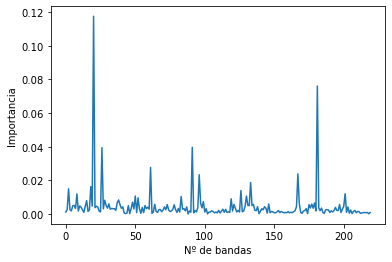

In [11]:
## Entrenamiento del modelo para conseguir un ranking de características ##

X,Y,Xl,Yl = sp.aviris_data_load()

X_train, X_test, y_train, y_test = train_test_split(Xl, Yl,random_state=1)

extra_tree = ExtraTreeClassifier(random_state=0, splitter ='best' )

clf = extra_tree.fit(X_train, y_train)

score = clf.score(X_test, y_test)

features = clf.feature_importances_

plt.plot(features)
plt.xlabel('Nº de bandas')
plt.ylabel('Importancia')


# Reducción de bandas o características

#Hemos escogido este criterio de 0.01, para reducir las bandas menos importantes y, vemos que el resultado es bastante bueno
indice= np.where(features< 0.01)

X_reduced2 = np.delete(X_reduced, indice, axis=1)
X_2 = np.delete(X.reshape([145*145,220]), indice, axis=1)


Cohen-kappa 0.6076501621845649


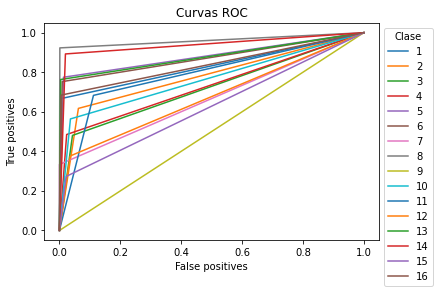

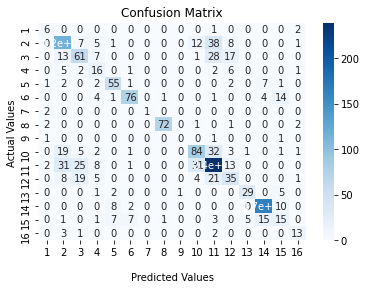

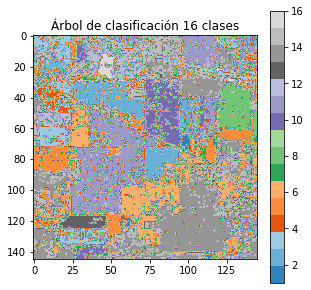

In [14]:
## Tree classifier ##

tag_list = np.arange(1,17)

criterion = 'gini'
max_depth = None

Xtr, Xts, ytr, yts = train_test_split(X_reduced2, Y_reduced, test_size=0.3)


tree = DecisionTreeClassifier(criterion=criterion)
tree.fit(Xtr, ytr)
ytree = tree.predict(Xts)

# Evaluate and compare results
print('Cohen-kappa', cohen_kappa_score(yts, ytree))

Conf_matrix_tree = confusion_matrix(yts, ytree)
Kappa_tree = cohen_kappa_score(yts, ytree)
sp.draw_ROC(yts,tree.predict_proba(Xts),tag_list)
sp.draw_ConfusionM(Conf_matrix_tree,tag_list)


X,a,a,a = sp.aviris_data_load()
image = tree.predict(X_2)
sp.draw_image(image,"Árbol de clasificación")

Hemos probado el conjunto de reducido, con las bandas más importantes, y con el clasificador de árbol, mejoramos los resultados a los obtenidos sin reducción.

5. Por último, empleando solo el conjunto reducido de muestras etiquetadas y las bandas seleccionadas, utilizar alguna estrategia de combinación de clasificadores (métodos 'ensemble') para intentar mejorar los resultados de la clasificación.

Cohen-kappa 0.7390198561856512


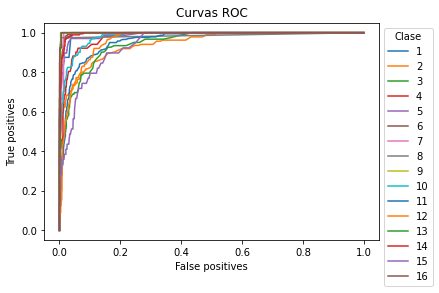

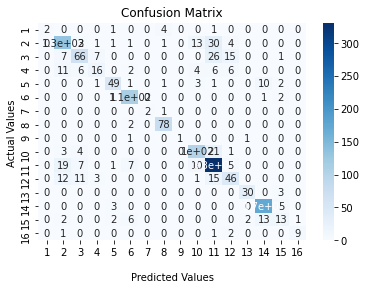

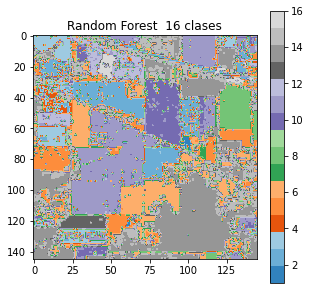

In [8]:
## Random forest (ensembles) ##

criterion = 'gini'
max_depth = None


Xtr, Xts, ytr, yts = train_test_split(X_reduced2, Y_reduced, test_size=0.3)
# Train RF ensemble
rf = RandomForestClassifier(n_estimators=200, criterion=criterion, random_state=100)
rf.fit(Xtr, ytr)
yb = rf.predict(Xts)

# Evaluate and compare results
print('Cohen-kappa',cohen_kappa_score(yts, yb))

Conf_matrix_RF = confusion_matrix(yts, yb)
Kappa_RF = cohen_kappa_score(yts, yb)

# Observamos como con el conjunto reducido de bandas, dejando solo 16 bandas, el ensemble funciona bastante bien con un
# cohen-kappa de ~0.74
tag_list = np.arange(1,17)
score = rf.predict_proba(Xts)
sp.draw_ROC(yts,score,tag_list)

sp.draw_ConfusionM(Conf_matrix_RF,tag_list)

X_ = np.delete(X.reshape([145*145,220]), indice, axis=1)
sp.draw_image(rf.predict(X_),"Random Forest ")